In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from environment import Environment, DirectedTree, DEFAULT, CONSTITUENT
from prouter import Router
from sampler import Sampler, STRATEGIES
import random
import os
from pathlib import Path
from tqdm import tqdm
from win10toast import ToastNotifier
toaster = ToastNotifier()
from environment import DEFAULT

c:\users\albert\projekte\swmmpulse\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# A Notebook to check the simulation data for errors
## Checking packet files for errors

In [5]:
fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
os.listdir(fdir)

['.idea',
 '.ipynb_checkpoints',
 '00_packets',
 '01_routetables',
 '02_processed',
 'analysis.ipynb',
 'at_distribution.ipynb',
 'at_distribution_massload.svg',
 'at_distribution_multipliers.svg',
 'at_distribution_percentage.svg',
 'at_distribution_traveltime.svg',
 'bulk_analysis.ipynb',
 'com2a_hydraulic.csv',
 'correlation_analysis_raw.svg',
 'correlation_analysis_sampling_window.svg',
 'cov_analysis_multi.ipynb',
 'cov_analysis_single.ipynb',
 'cov_analysis_strategies.ipynb',
 'cov_rna_timeseries_fraction_0007.svg',
 'cseries.csv',
 'defecation_patterns.emf',
 'defecation_patterns.eps',
 'defecation_patterns.png',
 'defecation_patterns.svg',
 'dispersion_comparison.ipynb',
 'external_data',
 'extract_ts_by_bins.ipynb',
 'Flow',
 'HS_calib_120_simp',
 'HS_calib_120_simp.chi',
 'HS_calib_120_simp.db',
 'HS_calib_120_simp.ini',
 'HS_calib_120_simp.inp',
 'HS_calib_120_simp.out',
 'HS_calib_120_simp.rpt',
 'HS_calib_120_simp.thm',
 'HS_calib_120_simp.tsd.ini',
 'lumberjack.log',
 'me

In [4]:
packetdir = fdir / "00_packets" / "00_run1"
packetfiles = os.listdir(packetdir)

### Check packetcounts and infection rates

In [5]:
def check_packetlist(plist_path):
    df_p = pd.read_json(plist_path)
    rowcount, colcount = df_p.shape
    infectedcount = df_p["classification"].value_counts()["infected"]
    return rowcount, infectedcount

In [26]:
nrows = []
ninf = []
for packetfile in tqdm(packetfiles, desc="evaluating packet-files"):
    rowcount, infectedcount = check_packetlist(packetdir / packetfile)
    nrows.append(rowcount)
    ninf.append(infectedcount)

toaster.show_toast("Analysis finished","Checking packet counts and infection rates finished")

evaluating packet-files: 100%|██████████| 2000/2000 [06:06<00:00,  5.46it/s]


True

How often did what number of packets occur?
58913    2000
dtype: int64
--> the result is good, if the number of packets does not vary
How often did what number of infected packets occur?
--> the result is good, if the number of scenarios for each infection rate remains uniform


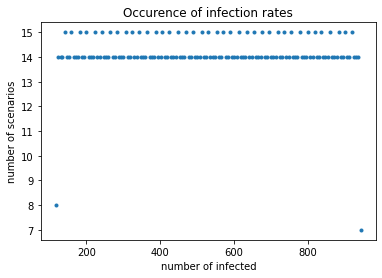

In [29]:
print(f"How often did what number of packets occur?")
print(pd.Series(nrows).value_counts())
print(f"--> the result is good, if the number of packets does not vary")

print(f"How often did what number of infected packets occur?")
pd.Series(ninf).value_counts().sort_index().plot(style=".", xlabel="number of infected", ylabel="number of scenarios", title="Occurence of infection rates")
print(f"--> the result is good, if the number of scenarios for each infection rate remains uniform")

### Check distribution of arrival times for some files

In [46]:
def check_arrivaltimes(packetfile):

    df_p = pd.read_json(packetfile)
    df_p["time"] = pd.to_datetime(10*df_p["t0"], unit="s")

    df_p["seconds"] = df_p["time"].dt.second
    distribution_seconds = df_p["seconds"].value_counts().sort_index()

    df_p["minutes"] = df_p["time"].dt.minute
    distribution_minutes = df_p["minutes"].value_counts().sort_index()

    return distribution_seconds, distribution_minutes

In [82]:
files_to_read = random.choices(packetfiles, k=500)

dis_sec, dis_min = check_arrivaltimes(packetdir/files_to_read[0])

i = 0
df_dis_secs = pd.DataFrame(dis_sec.rename(f"sample{i}"))
df_dis_mins = pd.DataFrame(dis_min.rename(f"sample{i}"))

for packetfile in tqdm(files_to_read[1:], desc="reading samples of packet-files..."):
    i += 1
    dis_sec, dis_min = check_arrivaltimes(packetdir/packetfile)
    df_dis_secs = df_dis_secs.join(dis_sec.rename(f"sample{i}"))
    df_dis_mins = df_dis_mins.join(dis_min.rename(f"sample{i}"))

toaster.show_toast("Analysis finished", "the random samples of packetfiles have been read")

reading samples of packet-files...: 100%|██████████| 499/499 [01:44<00:00,  4.79it/s]


True

### Distribution of seconds:

<AxesSubplot:>

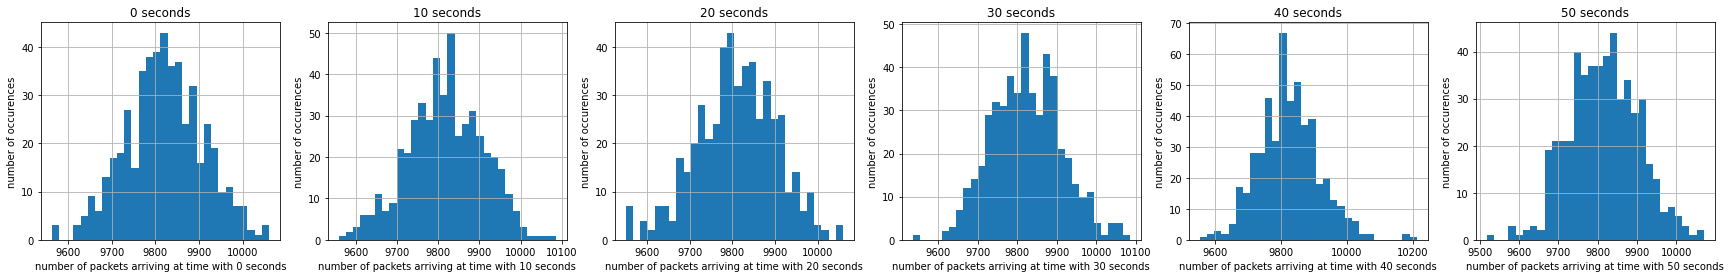

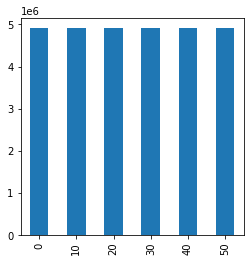

In [96]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=[30,4])
for i, second in enumerate(df_dis_secs.index):
    df_dis_secs.loc[second,:].hist(ax=axs[i], bins=30)

for i, ax in enumerate(axs):
    ax.set(title=f"{10*i} seconds",
           xlabel=f"number of packets arriving at time with {10*i} seconds",
           ylabel="number of occurences")

fig2, ax2 = plt.subplots(figsize=[4,4])
df_dis_secs.sum(axis=1).plot.bar()

### Distribution of minutes

In [72]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=[30,4])
for i, second in enumerate(df_dis_secs.index):
    df_dis_secs.loc[second,:].hist(ax=axs[i], bins=30)

<AxesSubplot:>

<AxesSubplot:title={'center':'Number of packets arriving at time with minute'}, xlabel='minute', ylabel='occurences'>

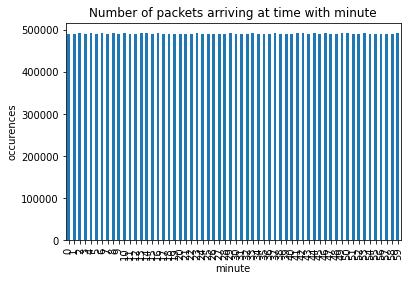

In [94]:
df_dis_mins.sum(axis=1).plot.bar(title="Number of packets arriving at time with minute",
                                 xlabel="minute",
                                 ylabel="occurences")

## Checking routetables for errors

In [129]:
rtdir = fdir / "01_routetables" / "00_run1"
rtfiles = os.listdir(rtdir)
rtfiles

['HS120_002_routetable_000000.json',
 'HS120_002_routetable_000001.json',
 'HS120_002_routetable_000002.json',
 'HS120_002_routetable_000003.json',
 'HS120_002_routetable_000004.json',
 'HS120_002_routetable_000005.json',
 'HS120_002_routetable_000006.json',
 'HS120_002_routetable_000007.json',
 'HS120_002_routetable_000008.json',
 'HS120_002_routetable_000009.json',
 'HS120_002_routetable_000010.json',
 'HS120_002_routetable_000011.json',
 'HS120_002_routetable_000012.json',
 'HS120_002_routetable_000013.json',
 'HS120_002_routetable_000014.json',
 'HS120_002_routetable_000015.json',
 'HS120_002_routetable_000016.json',
 'HS120_002_routetable_000017.json',
 'HS120_002_routetable_000018.json',
 'HS120_002_routetable_000019.json',
 'HS120_002_routetable_000020.json',
 'HS120_002_routetable_000021.json',
 'HS120_002_routetable_000022.json',
 'HS120_002_routetable_000023.json',
 'HS120_002_routetable_000024.json',
 'HS120_002_routetable_000025.json',
 'HS120_002_routetable_000026.json',
 

[Text(0.5, 1.0, 'Occurences of tas with minutes')]

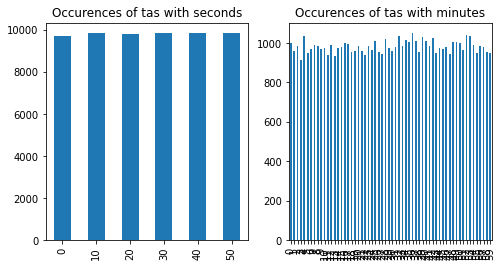

In [159]:
df_rt = pd.DataFrame(pd.read_json(rtdir / random.choice(rtfiles), typ="series").rename("ta"))
df_rt.head()
df_rt["time"] = pd.to_datetime(10*df_rt["ta"].astype("int"), unit="s")
df_rt["seconds"] = df_rt["time"].dt.second
df_rt["minutes"] = df_rt["time"].dt.minute

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8,4])
df_rt["seconds"].value_counts().sort_index().plot.bar(ax=ax1)
ax1.set(title="Occurences of tas with seconds")
df_rt["minutes"].value_counts().sort_index().plot.bar(ax=ax2)
ax2.set(title="Occurences of tas with minutes")

In [135]:
files_to_read = random.choices(processedfiles, k=10)

i = 0

df_timeseries = pd.DataFrame(pd.read_json(processeddir / files_to_read[0], typ="series").rename(f"sample{i}"))
for tsfile in files_to_read[1:]:
    i += 1
    df_timeseries = df_timeseries.join(pd.read_json(processeddir/tsfile, typ="series").rename(f"sample{i}"))

## Checking processed files for errors

In [100]:
processeddir = fdir / "02_processed" / "00_run1"
processedfiles = os.listdir(processeddir)

In [124]:
files_to_read = random.choices(processedfiles, k=10)

i = 0

df_timeseries = pd.DataFrame(pd.read_json(processeddir / files_to_read[0], typ="series").rename(f"sample{i}"))
for tsfile in files_to_read[1:]:
    i += 1
    df_timeseries = df_timeseries.join(pd.read_json(processeddir/tsfile, typ="series").rename(f"sample{i}"))

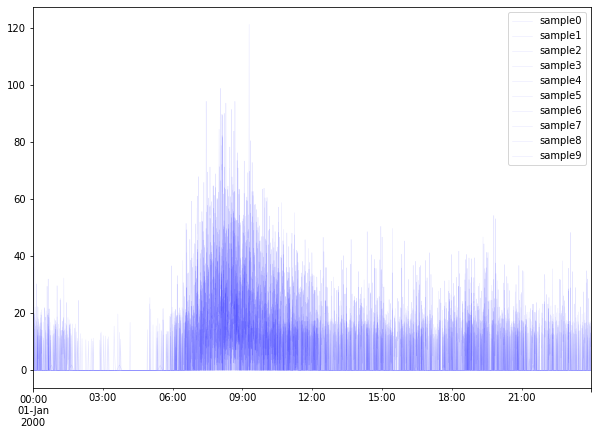

In [128]:
fig, ax = plt.subplots(figsize=[10, 7])
df_timeseries.plot(alpha=0.1, ax=ax, color="b", linewidth=0.5)
plt.savefig(fdir/"timeseries_alpha.png")

## Kolmogorov-Smirnov Test
Testing whether enough scenarios are calculated to recreate defecation pattern

In [47]:
fdir = Path(r"C:\Users\albert\Documents\SWMMpulse")
packetdir = fdir / "00_packets" / "00_run2"
packetfiles = os.listdir(packetdir)

reading and saving counts of infected packet origin times for later faster use

In [ ]:
def check_packetlist(plist_path):
    df_p = pd.read_json(plist_path)
    rowcount, colcount = df_p.shape
    infectedcount = df_p["classification"].value_counts()["infected"]
    return rowcount, infectedcount

In [64]:
df_distribution = pd.DataFrame(np.zeros(8640), index=np.arange(0,8640,1), columns=["packetcount"])
df_distribution

,packetcount
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
8635,0.0
8636,0.0
8637,0.0
8638,0.0


In [87]:
df_distribution = pd.DataFrame(index=np.arange(0,8640,1))

for i, pfile in tqdm(enumerate(packetfiles), desc="reading packetfiles..."):
    df_p = pd.read_json(packetdir/pfile)
    new_dis = df_p.loc[df_p["classification"] == "infected","t0"].value_counts().sort_index()
    df_distribution = df_distribution.join(new_dis.rename(f"dis{i:05d}"))

s_distribution = df_distribution.sum(axis=1)

reading packetfiles...: 10000it [1:02:18,  2.67it/s]


In [88]:
s_distribution.to_json(fdir/"plots"/"grfk_kolmogorov_smirnov"/"origin_times_distribution.json")

<AxesSubplot:xlabel='hour'>

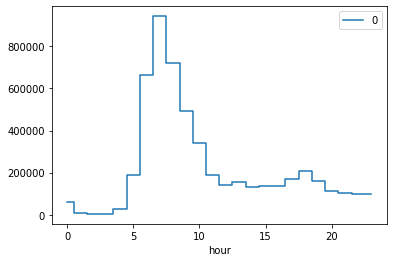

In [11]:
s_distribution = pd.read_json(fdir/"plots"/"grfk_kolmogorov_smirnov"/"origin_times_distribution.json", typ="series")
df_distribution = pd.DataFrame(s_distribution)
df_distribution["hour"] = df_distribution.index // 360
df_distribution.groupby("hour").sum().plot(drawstyle="steps-mid")

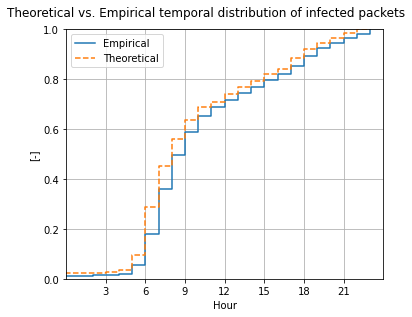

In [7]:
from scipy.stats import kstest

mc_dis_24h = df_distribution.groupby("hour").sum().values
mc_cum_24h = np.cumsum(mc_dis_24h) / np.sum(mc_dis_24h)
org_cum_24h = np.cumsum(DEFAULT.PATTERN_BRISTOL)/100

p_value = kstest(mc_cum_24h, org_cum_24h, N=24)

pd.DataFrame(mc_cum_24h)

fig, ax = plt.subplots(figsize=[5,4.3], constrained_layout=True)

fig.suptitle("Theoretical vs. Empirical temporal distribution of infected packets")

ax.set(xlabel="Hour", ylabel="[-]", xticks=np.arange(3,24,3), xlim=[0,24], ylim=[0,1])
ax.grid()

ax.step(x=np.arange(0,24,1), y=mc_cum_24h, where="post")
ax.step(x=np.arange(0,24,1), y=org_cum_24h, linestyle="dashed", linewidth=1.5)

ax.legend(["Empirical", "Theoretical"])

plt.savefig(fdir/"plots"/"grfk_kolmogorov_smirnov"/"ks-test.png")
plt.savefig(fdir/"plots"/"grfk_kolmogorov_smirnov"/"ks-test.svg")

In [45]:
abs_error_post = np.abs(mc_cum_24h - org_cum_24h)
mc_cum_24h_pre = np.roll(mc_cum_24h, 1)
mc_cum_24h_pre[0] = 0
abs_error_pre = np.abs(mc_cum_24h_pre - org_cum_24h)
max_error = np.max([abs_error_pre, abs_error_post])
max_error
#np.array([mc_cum_24h,org_cum_24h, abs_error]).T

0.10531552620142684

In [47]:
alpha = 0.05
Kalpha = np.sqrt(np.log(2/alpha)/2)
np.sqrt(24**2)

1.3581015157406195

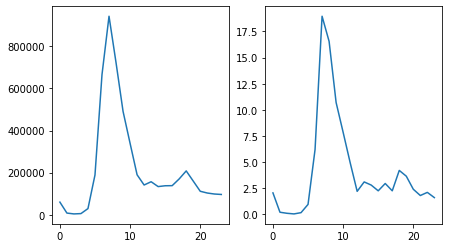

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[7,4])
ax1.plot(mc_dis_24h.T[0])
ax2.plot(DEFAULT.PATTERN_BRISTOL)

In [40]:
mc_dis_24h.T[0].shape

(24,)

In [12]:
df_ks_out = pd.DataFrame(np.array([np.arange(0,24,1), mc_cum_24h, mc_cum_24h_pre, org_cum_24h]).T, columns=["hour", "empirical_post", "empirical_pre", "theoretical"])
df_ks_out.to_parquet(fdir/"plots"/"grfk_kolmogorov_smirnov"/"ks-distributions.parquet")

C:\Users\albert\AppData\Local\Temp\ipykernel_11188\2302748553.py:2: RuntimeWarning: divide by zero encountered in log
  return (-0.5*np.log(alpha/2))**0.5/24**0.5


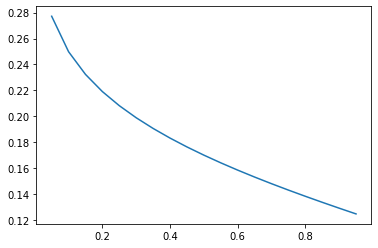

In [146]:
def dalpha(alpha):
        return (-0.5*np.log(alpha/2))**0.5/24**0.5

x = np.arange(0,1,0.05)
y = dalpha(x)
plt.plot(x, y)

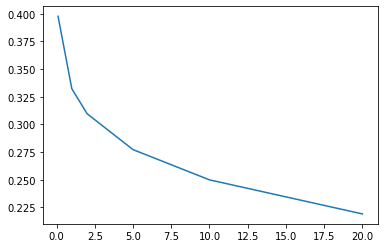

In [149]:
z = 24**0.5
x = [0.1, 1.0, 2.0, 5.0, 10.0, 20.0]
y = [1.949/z, 1.628/z, 1.517/z, 1.358/z, 1.224/z, 1.073/z]

plt.plot(x,y)

In [13]:
np.sqrt(48/24**2)

0.28867513459481287

In [14]:
24**2

576

KstestResult(statistic=0.20833333333333334, pvalue=0.686017125117228)